In [1]:
import pandas as pd
import tensorflow as tf
from imblearn.under_sampling import RandomUnderSampler
import os
os.chdir("/home/adl.mc5104/adl-fall2022-prj")
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import doc.core.model
from importlib import reload
reload(doc.core.model)
from doc.core.model import get_InceptionHierarchicalMagnification_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import RMSprop

2022-12-24 01:41:22.392281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-24 01:41:22.658948: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-24 01:41:24.285362: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-12-24 01:41:24.285478: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer

## Spliting the dev set and the test set: 

In [2]:
with open("./data/slides_name.txt") as file:
    tumor_slides_name = file.read().splitlines()
    tumor_slides_name = ["tumor_"+number for number in tumor_slides_name]
dev_slides, test_slides = train_test_split(tumor_slides_name,test_size=0.1,random_state=42)
train_slides, val_slides = train_test_split(dev_slides,test_size=0.11,random_state=42)

In [3]:
df = pd.read_csv("./data/patches_tumor_label.csv",names=["zoom_x1","zoom_x2","zoom_x8","label"])
level_of_zooms = list(filter(lambda column : "zoom" in column, df.columns))
df

,zoom_x1,zoom_x2,zoom_x8,label
0,./data/patches/zoom_x1/tumor_001_101.jpg,./data/patches/zoom_x2/tumor_001_101.jpg,./data/patches/zoom_x8/tumor_001_101.jpg,0
1,./data/patches/zoom_x1/tumor_001_102.jpg,./data/patches/zoom_x2/tumor_001_102.jpg,./data/patches/zoom_x8/tumor_001_102.jpg,0
2,./data/patches/zoom_x1/tumor_001_103.jpg,./data/patches/zoom_x2/tumor_001_103.jpg,./data/patches/zoom_x8/tumor_001_103.jpg,0
3,./data/patches/zoom_x1/tumor_001_104.jpg,./data/patches/zoom_x2/tumor_001_104.jpg,./data/patches/zoom_x8/tumor_001_104.jpg,0
4,./data/patches/zoom_x1/tumor_001_105.jpg,./data/patches/zoom_x2/tumor_001_105.jpg,./data/patches/zoom_x8/tumor_001_105.jpg,0
...,...,...,...,...
520553,./data/patches/zoom_x1/tumor_110_101062.jpg,./data/patches/zoom_x2/tumor_110_101062.jpg,./data/patches/zoom_x8/tumor_110_101062.jpg,0
520554,./data/patches/zoom_x1/tumor_110_101064.jpg,./data/patches/zoom_x2/tumor_110_101064.jpg,./data/patches/zoom_x8/tumor_110_101064.jpg,0
520555,./data/patches/zoom_x1/tumor_110_101072.jpg,./data/patches/zoom_x2/tumor_110_101072.jpg,./data/patches/zoom_x8/tumor_110_101072.jpg,0
520556,./data/patches/zoom_x1/tumor_110_101542.jpg,./data/patches/zoom_x2/tumor_110_101542.jpg,./data/patches/zoom_x8/tumor_110_101542.jpg,0


In [4]:
level_of_zooms = sorted(level_of_zooms,key=lambda x: int(x[-1]),reverse=True)

In [5]:
train_mask = df["zoom_x1"].str.contains("(?:"+"|".join(train_slides)+")")
train_df = df[train_mask]

In [6]:
val_mask = df["zoom_x1"].str.contains("(?:"+"|".join(val_slides)+")")
val_df = df[val_mask]

In [7]:
test_mask = df["zoom_x1"].str.contains("(?:"+"|".join(test_slides)+")")
test_df = df[test_mask]

In [8]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [54]:
image_ds = {}
images = train_df[level_of_zooms]
label = train_df["label"]
rus = RandomUnderSampler(random_state=124)
resample_images, resample_label = rus.fit_resample(images,label)
resample_images, resample_label = shuffle(resample_images,resample_label)
for zoom in level_of_zooms:
    path_ds = tf.data.Dataset.from_tensor_slices(resample_images[zoom])
    image_ds[zoom] = path_ds.map(load_and_preprocess_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(resample_label)
train_ds = tf.data.Dataset.zip((image_ds,label_ds)).shuffle(500).batch(32)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
print(len(train_ds))

3120


In [55]:
image_ds = {}
images = val_df[level_of_zooms]
label = val_df["label"]
for zoom in level_of_zooms:
    path_ds = tf.data.Dataset.from_tensor_slices(images[zoom])
    image_ds[zoom] = path_ds.map(load_and_preprocess_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(label)
val_ds = tf.data.Dataset.zip((image_ds,label_ds)).shuffle(500).batch(32)
val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
print(len(val_ds))

1105


In [56]:
image_ds = {}
images = test_df[level_of_zooms]
label = test_df["label"]
for zoom in level_of_zooms:
    path_ds = tf.data.Dataset.from_tensor_slices(images[zoom])
    image_ds[zoom] = path_ds.map(load_and_preprocess_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(label)
test_ds = tf.data.Dataset.zip((image_ds,label_ds)).shuffle(500).batch(32)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
print(len(test_ds))

3204


In [57]:
model = get_InceptionHierarchicalMagnification_model(level_of_zooms,trainable=False,dropout_rate=0.5)

In [58]:
model._name = "IHM_model_3"

In [59]:
model.summary()

Model: "IHM_model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_46 (InputLayer)          [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_aug_layer_21 (DataAugLaye  (None, 299, 299, 3)  0          ['input_46[0][0]']               
 r)                                                                                               
                                                                                                  
 inception_v3_zoom_x8 (Function  (None, 2048)        21802784    ['data_aug_layer_21[0][0]']      
 al)                                                                                    

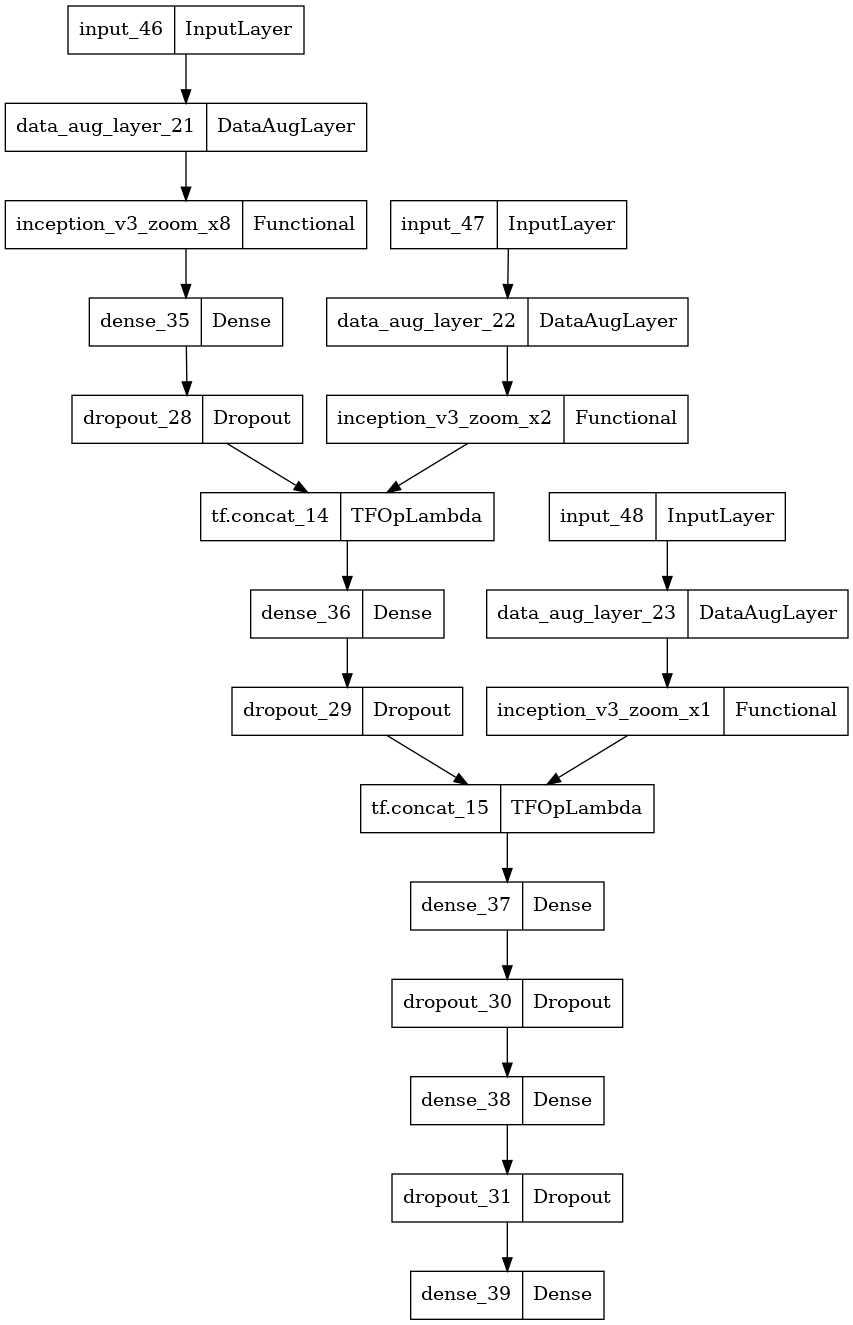

In [60]:
plot_model(model, to_file='./figs/model.png')

In [61]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=5e-3,
    decay_steps=100_000,
    decay_rate=0.5)
model.compile(
    optimizer=RMSprop(
        learning_rate=lr_schedule,
        rho=0.9,
        momentum = 0.9,
        epsilon=1.0
    ), 
    loss='binary_crossentropy',
    metrics=['accuracy','AUC']
)

In [62]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "./output/checkpoints/"+model.name,
    monitor="val_auc",
    save_best_only=True
)
hist = model.fit(train_ds,epochs=5,validation_data=val_ds,callbacks=checkpoint_callback)

Epoch 1/5


2022-12-24 09:06:00.488170: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: IHM_model_3/data_aug_layer_22/rot90/Assert/AssertGuard/branch_executed/_27
2022-12-24 09:06:11.687773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 385 of 500
2022-12-24 09:06:14.488362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


3120/3120 [==============================] - ETA: 0s - loss: 0.2315 - accuracy: 0.9089 - auc: 0.9661

2022-12-24 09:26:27.228015: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: IHM_model_3/data_aug_layer_22/rot90/Assert/AssertGuard/branch_executed/_27


INFO:tensorflow:Assets written to: ./output/checkpoints/IHM_model_3/assets


INFO:tensorflow:Assets written to: ./output/checkpoints/IHM_model_3/assets


3120/3120 [==============================] - 1741s 549ms/step - loss: 0.2315 - accuracy: 0.9089 - auc: 0.9661 - val_loss: 0.0953 - val_accuracy: 0.9746 - val_auc: 0.9178
Epoch 2/5
3120/3120 [==============================] - ETA: 0s - loss: 0.1524 - accuracy: 0.9426 - auc: 0.9846

INFO:tensorflow:Assets written to: ./output/checkpoints/IHM_model_3/assets


INFO:tensorflow:Assets written to: ./output/checkpoints/IHM_model_3/assets


3120/3120 [==============================] - 1688s 540ms/step - loss: 0.1524 - accuracy: 0.9426 - auc: 0.9846 - val_loss: 0.0904 - val_accuracy: 0.9826 - val_auc: 0.9105
Epoch 3/5
3120/3120 [==============================] - 1593s 510ms/step - loss: 0.1356 - accuracy: 0.9487 - auc: 0.9878 - val_loss: 0.1576 - val_accuracy: 0.9445 - val_auc: 0.9289
Epoch 4/5
3120/3120 [==============================] - ETA: 0s - loss: 0.1291 - accuracy: 0.9522 - auc: 0.9888

INFO:tensorflow:Assets written to: ./output/checkpoints/IHM_model_3/assets


INFO:tensorflow:Assets written to: ./output/checkpoints/IHM_model_3/assets


3120/3120 [==============================] - 1685s 540ms/step - loss: 0.1291 - accuracy: 0.9522 - auc: 0.9888 - val_loss: 0.0468 - val_accuracy: 0.9911 - val_auc: 0.9013
Epoch 5/5
3120/3120 [==============================] - 1589s 509ms/step - loss: 0.1242 - accuracy: 0.9528 - auc: 0.9897 - val_loss: 0.0571 - val_accuracy: 0.9847 - val_auc: 0.9297


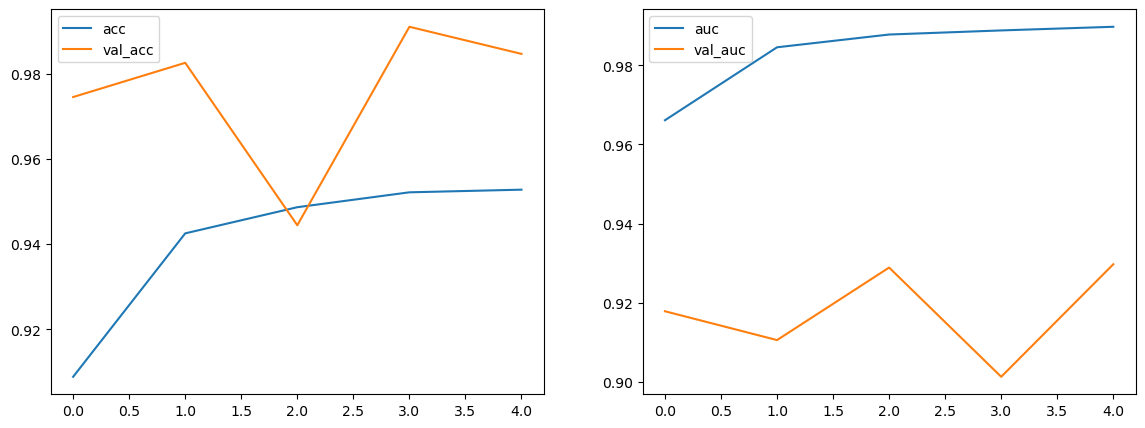

In [63]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,5))
axs = fig.subplots(1,2)
axs[0].plot(hist.history["accuracy"],label="acc")
axs[0].plot(hist.history["val_accuracy"],label="val_acc")
axs[0].legend()
axs[1].plot(hist.history["auc"],label="auc")
axs[1].plot(hist.history["val_auc"],label="val_auc")
axs[1].legend()

### Fine tuning the Inception towers :

Fine tuning the inception towers lead to a model overfitting on the training set...

In [21]:
FINE_TUNE_AT = 200

In [22]:
for zoom in level_of_zooms:
    inception_tower = model.get_layer("inception_v3_"+zoom)
    inception_tower.trainable = True
    for layer in inception_tower.layers[:FINE_TUNE_AT]:
        layer.trainable = False
model.summary()

Model: "IHM_model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_aug_layer (DataAugLayer)  (None, 299, 299, 3)  0           ['input_4[0][0]']                
                                                                                                  
 inception_v3_zoom_x8 (Function  (None, 2048)        21802784    ['data_aug_layer[0][0]']         
 al)                                                                                              
                                                                                        

In [23]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=100_000,
    decay_rate=0.5)
model.compile(
    optimizer=RMSprop(
        learning_rate=lr_schedule,
        rho=0.9,
        momentum = 0.9,
        epsilon=1.0
    ), 
    loss='binary_crossentropy',
    metrics=['accuracy','AUC']
)

In [24]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "./output/checkpoints",
    monitor="val_auc",
    save_best_only=True
)
hist = model.fit(train_ds,epochs=8,validation_data=val_ds,callbacks=checkpoint_callback,initial_epoch=5)

Epoch 6/8


2022-12-24 04:04:14.804570: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: IHM_model_1/data_aug_layer_1/rot90/Assert/AssertGuard/branch_executed/_27


3120/3120 [==============================] - ETA: 0s - loss: 0.1553 - accuracy: 0.9418 - auc: 0.9844

2022-12-24 04:36:49.346729: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: IHM_model_1/data_aug_layer_2/rot90/Assert/AssertGuard/branch_executed/_46


INFO:tensorflow:Assets written to: ./output/checkpoints/assets


INFO:tensorflow:Assets written to: ./output/checkpoints/assets


3120/3120 [==============================] - 2477s 788ms/step - loss: 0.1553 - accuracy: 0.9418 - auc: 0.9844 - val_loss: 0.0848 - val_accuracy: 0.9850 - val_auc: 0.9238
Epoch 7/8
3120/3120 [==============================] - ETA: 0s - loss: 0.0934 - accuracy: 0.9664 - auc: 0.9938

INFO:tensorflow:Assets written to: ./output/checkpoints/assets


INFO:tensorflow:Assets written to: ./output/checkpoints/assets


3120/3120 [==============================] - 2462s 789ms/step - loss: 0.0934 - accuracy: 0.9664 - auc: 0.9938 - val_loss: 0.0628 - val_accuracy: 0.9876 - val_auc: 0.9008
Epoch 8/8
3120/3120 [==============================] - 2360s 756ms/step - loss: 0.0724 - accuracy: 0.9747 - auc: 0.9961 - val_loss: 0.0530 - val_accuracy: 0.9877 - val_auc: 0.9186


### Evaluate Model :

#### Classification Metrics :

In [64]:
model.load_weights("./output/checkpoints/IHM_model_1")
model.evaluate(test_ds)

2022-12-24 11:24:05.054261: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./output/checkpoints/IHM_model_1: FAILED_PRECONDITION: output/checkpoints/IHM_model_1; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


3204/3204 [==============================] - 1209s 377ms/step - loss: 0.1329 - accuracy: 0.9523 - auc: 0.9639


[0.13288666307926178, 0.9523019790649414, 0.9639328122138977]

In [65]:
model_2 = get_InceptionHierarchicalMagnification_model(level_of_zooms,trainable=False,dropout_rate=0.5)
model_2.load_weights("./output/checkpoints/IHM_model_2/")
model_2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy','AUC']
)
model_2.evaluate(test_ds)

2022-12-24 11:44:32.372828: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./output/checkpoints/IHM_model_2/: FAILED_PRECONDITION: output/checkpoints/IHM_model_2; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2022-12-24 11:44:44.345514: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_8/data_aug_layer_24/rot90/Assert/AssertGuard/branch_executed/_8


3204/3204 [==============================] - 1218s 378ms/step - loss: 0.0647 - accuracy: 0.9752 - auc: 0.9738


[0.06470722705125809, 0.9751755595207214, 0.9738348722457886]

In [66]:
model_3 = get_InceptionHierarchicalMagnification_model(level_of_zooms,trainable=False,dropout_rate=0.5)
model_3.load_weights("./output/checkpoints/IHM_model_3/")
model_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy','AUC']
)
model_3.evaluate(test_ds)

2022-12-24 12:05:05.575041: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./output/checkpoints/IHM_model_3/: FAILED_PRECONDITION: output/checkpoints/IHM_model_3; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?
2022-12-24 12:05:17.241920: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: model_9/data_aug_layer_27/rot90/Assert/AssertGuard/branch_executed/_8


3204/3204 [==============================] - 1216s 377ms/step - loss: 0.0909 - accuracy: 0.9687 - auc: 0.9686


[0.09088686853647232, 0.9687182903289795, 0.9686024785041809]

#### Object detection Metric - Generating the Heatmap :

In [67]:
import doc.core.sliding_window
reload(doc.core.sliding_window)
from doc.core.sliding_window import read_slide
from doc.core.utils import custom_logger
import time
from tqdm import tqdm
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version

In [68]:
patch_directory = "./data/patches/{:s}"
patches = os.path.join(patch_directory,"{:s}_{:d}.jpg")

In [69]:
import re

def build_heatmap_slide(logger,slide, args, models ,batch_size):

    slide_name = slide+'.tif'
    tumor_mask_name = slide+'_mask.tif'

    logger.info(
        f"Building the heatmap patches for the slide {slide_name} from model "
        +", ".join([model.name for model in models])
        )

    slide_path = os.path.join('./data',slide_name) 
    tumor_mask_path = os.path.join('./data', tumor_mask_name)

    slide_url = 'https://storage.googleapis.com/adl2022-slides/%s' % slide_name
    mask_url = 'https://storage.googleapis.com/adl2022-slides/%s' % tumor_mask_name

    # Download the whole slide image
    if not os.path.exists(slide_path):

        logger.info(f"Missing slide downloading it from {slide_url}")

        os.chdir("./data/")
        os.system(f"curl -O {slide_url}")
        os.chdir("..")

    # Download the tumor mask
    if not os.path.exists(tumor_mask_path):

        logger.info(f"Missing mask slide downloading it from {mask_url}")

        os.chdir("./data/")
        os.system(f"curl -O {mask_url}")
        os.chdir("..")
    
    logger.info("Opening the slide/mask")

    tumor_mask = open_slide(tumor_mask_path)
    dimensions = tumor_mask.level_dimensions[args.level]
    real_heatmap = read_slide(tumor_mask,(0,0),args.level,dimensions)
    real_heatmap = real_heatmap[:,:,0]
    windows =[
            (x,y) for y in range(0,dimensions[1],args.stride) for x in range(0,dimensions[0],args.stride)
            ]
    t = time.time()

    mask = df["zoom_x1"].str.contains(slide)
    paths = df[mask]
    patches_numbers = df[mask].zoom_x1.apply(lambda x: int(re.findall(slide+"_(\d+)",x)[0])).to_list()
    ds = tf.data.Dataset.from_tensor_slices(df[mask].to_dict(orient="list"))
    ds = ds.map(
        lambda x: {zoom : load_and_preprocess_image(x[zoom]) for zoom in level_of_zooms},
        num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
    ds = ds.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    logger.info(f"Predicting the {len(ds)*batch_size} tissues patches of slide {slide}")
    # predicting the tissue patches in the slides :
    ensemble_pred = []
    for model in models :
        pred = []
        for batch in tqdm(ds,total=len(ds)):
            pred.append(model(batch))
        pred = tf.concat(pred,axis=0)
        ensemble_pred.append(pred)
    ensemble_pred = tf.concat(ensemble_pred,axis=1)
    saved_pred = pd.DataFrame(ensemble_pred.numpy(),index=patches_numbers)
    print(saved_pred.head())
    saved_pred.to_csv('./output/predictions_'+slide+'.csv')
    pred = tf.reduce_mean(ensemble_pred,axis=1)
    print(pred.shape)
    pred_heatmap = np.zeros((dimensions[1],dimensions[0]))
    logger.info("Filling the heatmap with our precomputed predictions")
    with tqdm(range(len(windows)),leave=False) as p_bar:
        for i in p_bar:
            if i in patches_numbers:
                x,y = windows[i]
                pred_heatmap[y:(y+args.stride),x:(x+args.stride)] = pred[patches_numbers.index(i)]

    logger.info(f"Building the heatmap from the slide {slide_name} took {round(time.time()-t)} seconds")

    os.remove(slide_path)
    os.remove(tumor_mask_path)

    logger.info("Deleting from disk the downloaded slides")

    return real_heatmap, pred_heatmap, pred

In [70]:
class CustomArgParse():
    def __init__(
        self,
        level_of_zooms=["zoom_x1","zoom_x2","zoom_x8"],
        window_size = 299,
        stride = 32,
        level = 3,
        gray_threshold = 0.8,
        pixel_threshold = 0.2
        ):
        self.level_of_zooms = level_of_zooms
        self.window_size = window_size
        self.stride = stride
        self.level = level
        self.gray_threshold = 0.8
        self.pixel_threshold = 0.2

In [71]:
import logging
reload(logging)
logger = custom_logger()
list_heatmap = {}
args = CustomArgParse(level_of_zooms=level_of_zooms)
for slide in test_slides:
    list_heatmap[slide] = build_heatmap_slide(logger,slide,args,[model,model_2,model_3],batch_size=64)

12:25:28--INFO : Building the heatmap patches for the slide tumor_001.tif from model IHM_model_3, model_8, model_9
12:25:28--INFO : Missing slide downloading it from https://storage.googleapis.com/adl2022-slides/tumor_001.tif
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3113M  100 3113M    0     0   166M      0  0:00:18  0:00:18 --:--:--  202M
12:25:47--INFO : Missing mask slide downloading it from https://storage.googleapis.com/adl2022-slides/tumor_001_mask.tif
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 93.8M  100 93.8M    0     0  91.8M      0  0:00:01  0:00:01 --:--:-- 91.8M
12:25:48--INFO : Opening the slide/mask
12:26:02--INFO : Predicting the 36608 tissues patches of slide tumor_001
100%|██████████| 572/572 [08:07<00:00,  1.17it/s]
12:50:27--INFO :

            0         1         2
101  0.007972  0.000714  0.015934
102  0.009262  0.000874  0.023872
103  0.020719  0.001518  0.020344
104  0.072577  0.002089  0.033410
105  0.025591  0.000895  0.016947
(36547,)


12:52:21--INFO : Building the heatmap from the slide tumor_001.tif took 1581 seconds
12:52:22--INFO : Deleting from disk the downloaded slides
12:52:22--INFO : Building the heatmap patches for the slide tumor_094.tif from model IHM_model_3, model_8, model_9
12:52:22--INFO : Missing slide downloading it from https://storage.googleapis.com/adl2022-slides/tumor_094.tif
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1534M  100 1534M    0     0   172M      0  0:00:08  0:00:08 --:--:--  162M
12:52:31--INFO : Missing mask slide downloading it from https://storage.googleapis.com/adl2022-slides/tumor_094_mask.tif
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 51.7M  100 51.7M    0     0   110M      0 --:--:-- --:--:-- --:--:--  110M
12:52:31--INFO : Opening the slide/m

             0         1         2
1768  0.010358  0.001060  0.004037
2515  0.004545  0.000421  0.002750
2802  0.005378  0.000168  0.008545
3668  0.022878  0.000988  0.033846
3669  0.018973  0.000961  0.025252
(43048,)


13:22:47--INFO : Building the heatmap from the slide tumor_094.tif took 1809 seconds
13:22:47--INFO : Deleting from disk the downloaded slides
13:22:47--INFO : Building the heatmap patches for the slide tumor_084.tif from model IHM_model_3, model_8, model_9
13:22:47--INFO : Missing slide downloading it from https://storage.googleapis.com/adl2022-slides/tumor_084.tif
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  799M  100  799M    0     0   115M      0  0:00:06  0:00:06 --:--:--  127M
13:22:55--INFO : Missing mask slide downloading it from https://storage.googleapis.com/adl2022-slides/tumor_084_mask.tif
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.7M  100 24.7M    0     0  58.2M      0 --:--:-- --:--:-- --:--:-- 58.2M
13:22:55--INFO : Opening the slide/m

             0         1         2
895   0.003569  0.000150  0.006707
896   0.006487  0.000149  0.015050
3369  0.030649  0.035615  0.009286
5820  0.017816  0.001159  0.005258
5821  0.011900  0.003582  0.003998
(22925,)


13:38:44--INFO : Building the heatmap from the slide tumor_084.tif took 946 seconds
13:38:44--INFO : Deleting from disk the downloaded slides


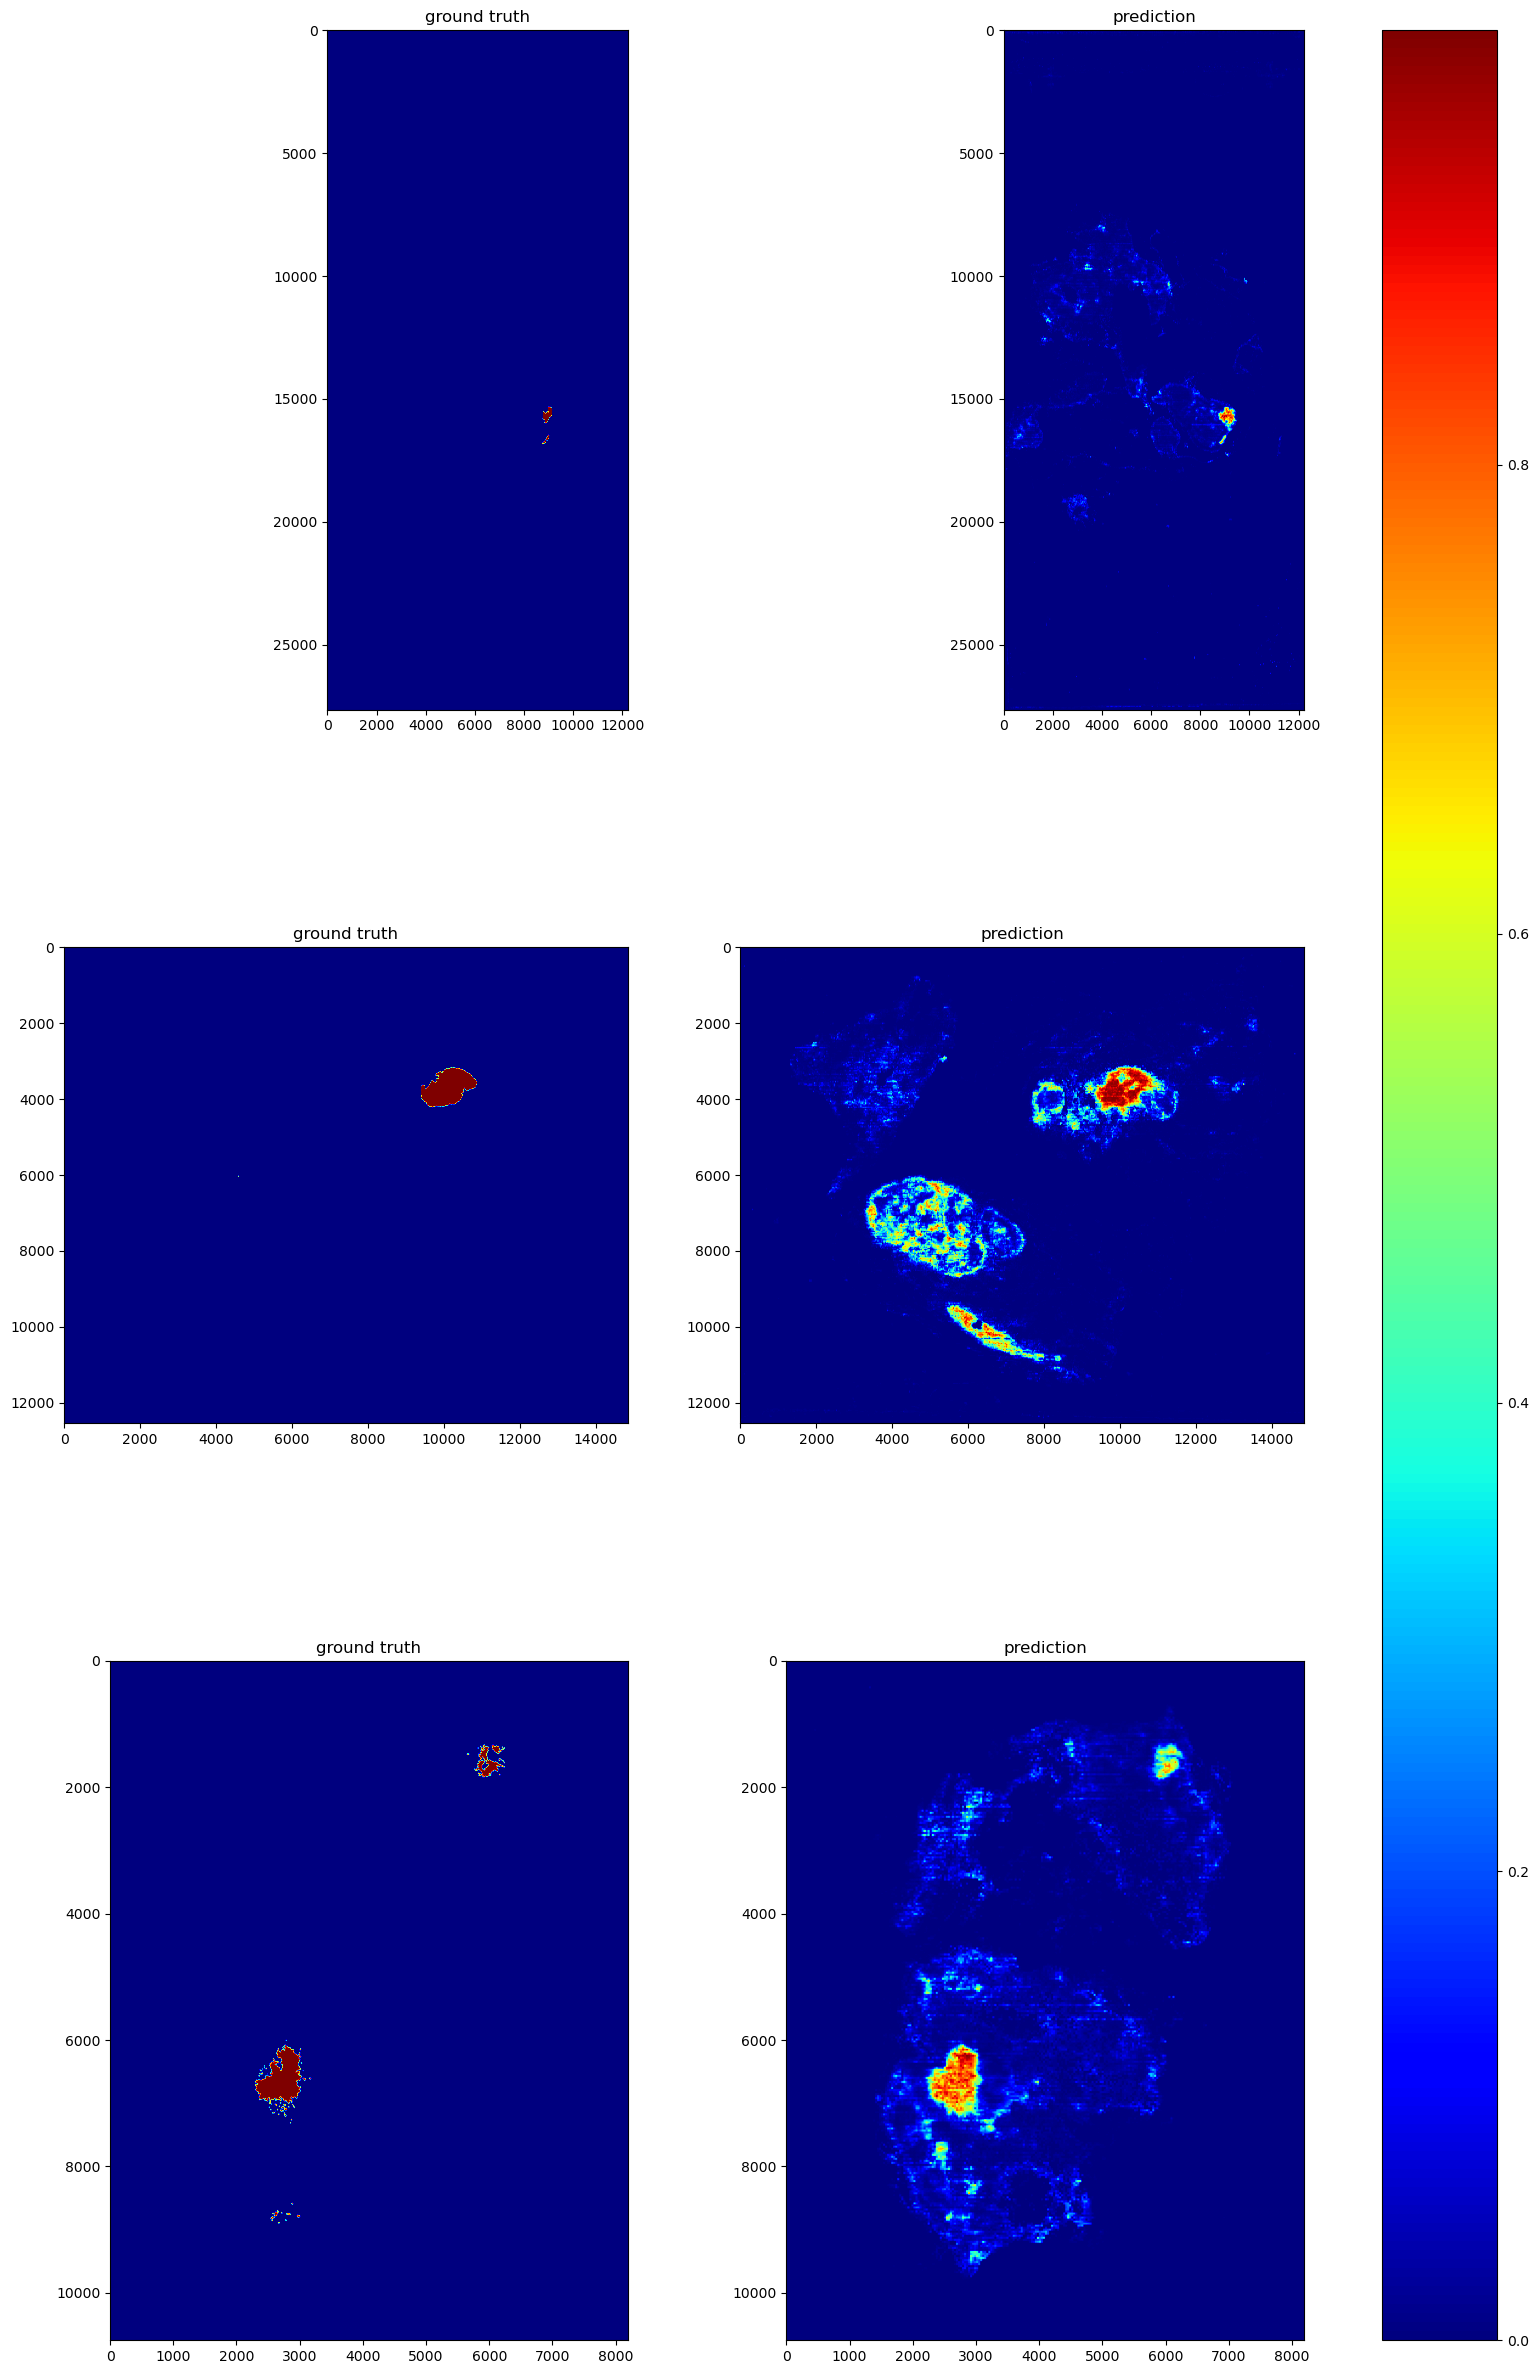

In [72]:
fig = plt.figure(figsize=(20,30), dpi=100)
axs = fig.subplots(3,2)
for i,slide in enumerate(test_slides):
    r_heatmap, p_heatmap, _ = list_heatmap[slide]
    axs[i,0].imshow(r_heatmap,cmap='jet')
    axs[i,0].set_title("ground truth")
    im = axs[i,1].imshow(p_heatmap,cmap='jet')
    axs[i,1].set_title("prediction")
plt.colorbar(im, ax=axs.ravel().tolist())
plt.show()

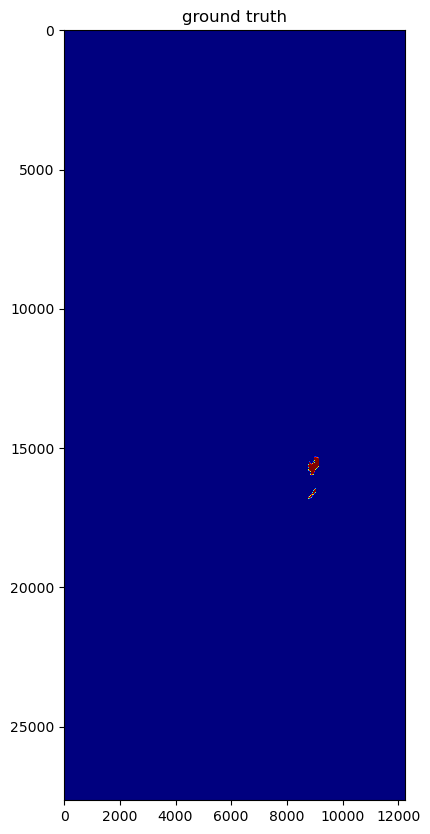

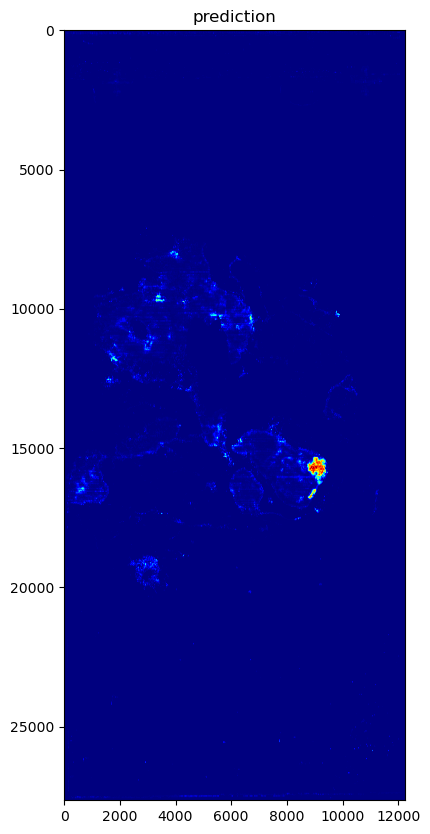

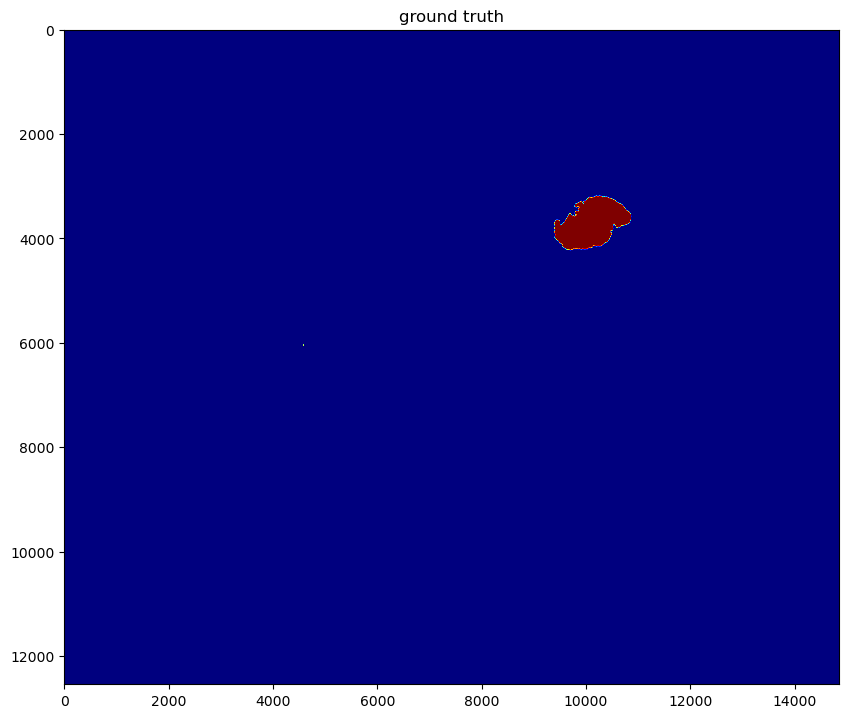

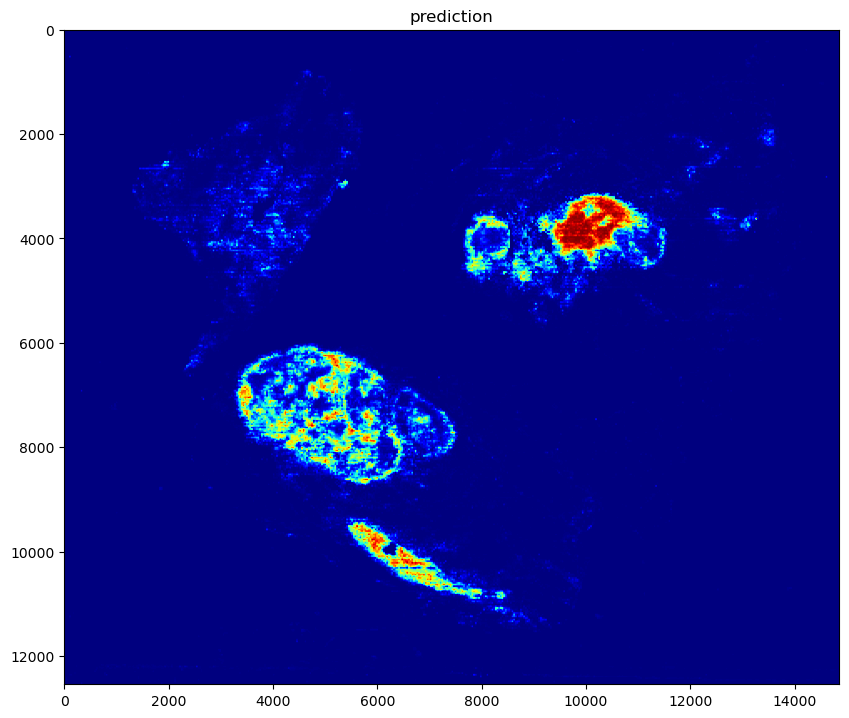

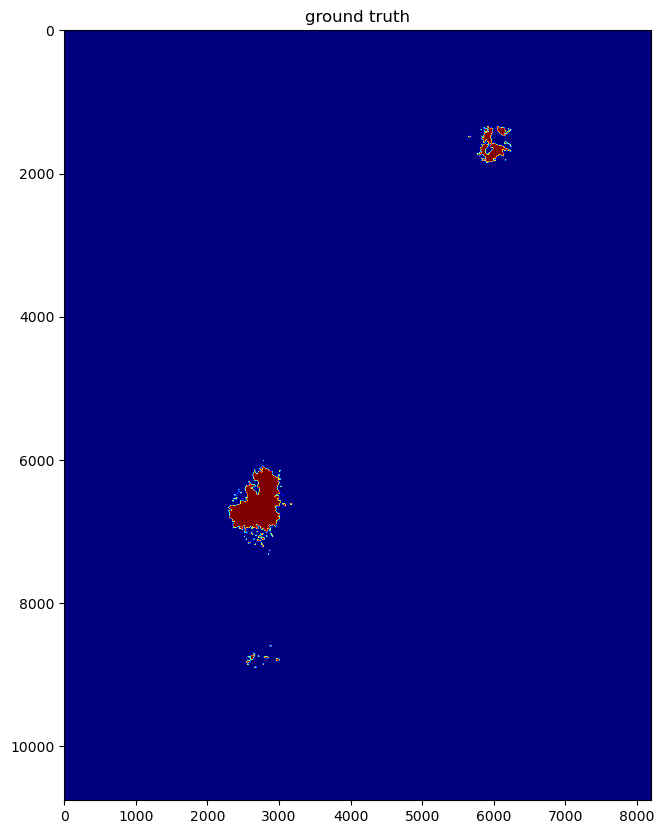

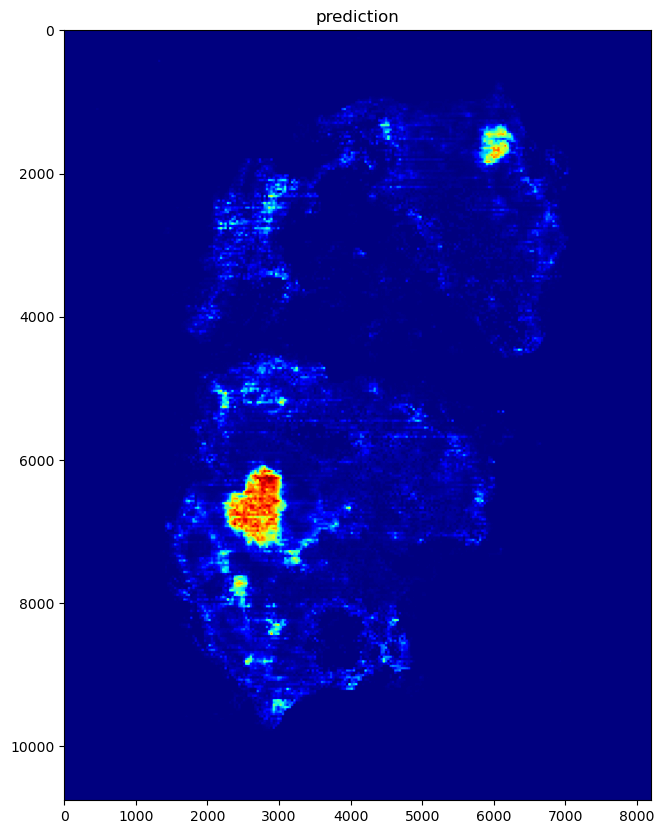

In [73]:
for i,slide in enumerate(test_slides):
    r_heatmap, p_heatmap, _ = list_heatmap[slide]
    fig = plt.figure(figsize=(10,10), dpi=100)
    ax = fig.subplots()
    ax.imshow(r_heatmap,cmap='jet')
    ax.set_title("ground truth")
    fig.savefig("./figs/ground_truth_"+slide)
    fig = plt.figure(figsize=(10,10), dpi=100)
    ax = fig.subplots()
    ax.imshow(p_heatmap,cmap='jet')
    ax.set_title("prediction")
    fig.savefig("./figs/prediction_"+slide)